# Bootstrap Distance Imposters

This method is novel, so as with all new things it should be taken with a grain of salt. One problem with GI (as discussed in the [GI Notebook](nux_imposters_ngram.ipynb)) is that it can be difficult to interpret at the high confidence end. This method extends the basic idea by measuring a complete _distance distribution_. In general, given a vector distance function $d(x,y)$ and some variables: $x$ an unknown text; $c_i \in C$ a set of candidate documents; and $y_j \in Y$ a set of imposter documents, GI estimates by boostrap the *single probability* that $min(d(x,C)) < min(d(x,Y))$ ('likelihood a candidate is closer than an imposter'). By contrast, this method records at each iteration $D \coloneqq min(d(x,Y)) - min(d(x,C))$ the _distance_ between the closest candidate and the closest imposter. For situations where $x$ is not by the candidate author we would expect $E[D] \approx 0$ (since the candidates are also imposters), whereas if the candidate is the true author the distance distribution will be centred around a positive number (distance to candidate tends to be less than distance to imposter). In situations of mistaken identity, when the true author is actually among the imposters, then $E[D]$ will be significantly below zero--something that is also not visible with GI. For those who desperately crave _p_-values, the probability mass that is less than zero represents the uncertainty.

This seems more (statistically) powerful in this particular application (not here, but in the [poetry analysis](nux_boot_poet.ipynb)), and provides results that are much more interpretable, since results that are simply "1" in GI (a candidate text was closest in every iteration) will now return full distributions, even if every difference > 0.

The method was accepted after peer review as a full paper at [CHR 2024](https://ceur-ws.org/Vol-3834/) [direct link](https://ceur-ws.org/Vol-3834/paper61.pdf) which has much more detail.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

from ruzicka.BDIVerifier import BDIVerifier

In [ ]:
%load_ext rpy2.ipython

## Vectorizing

Here we use the same configuration as for the [GI Notebook](nux_imposters_ngram.ipynb), i.e. 5000 most-frequent 2-,3-, and 4-grams, with _z_-scaling.

In [218]:
nini_vec = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l1",
        analyzer="char",
        ngram_range=(3, 5),
        max_features=5000,
    ),
    FunctionTransformer(lambda x: np.array(x.todense()), accept_sparse=True),
)

In [219]:
vecs = pd.read_csv("elegy_corpus.csv", index_col=0)
non_elegy_vecs = pd.read_csv("non_elegy_corpus.csv", index_col=0)

## Corpus

See [this notebook](build_corpus.ipynb) for corpus creation details. I use Augustan 'short elegy' as elsewhere, but no poem that is less than twenty lines. In addition, I include 200 samples with length $\sim N(80,20)$ drawn from assorted works of epic hexameter.

In [220]:
corpus = pd.concat([vecs, non_elegy_vecs])

In [221]:
test_corpus = corpus[corpus.Author != "ps-Ovid"]
test_corpus = test_corpus[test_corpus.LEN >= 20]
test_corpus

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
195,V.Flaccus,195-Argonautica,195-Argonautica,62,eumenidumkwe komae non tristis ab aetere gorgo...
196,Lucretius,196-DRN,196-DRN,92,kernere koeperunt kontendere _satkwe parare\nn...
197,Horace,197-Hor.,197-Hor. Sat.,72,kwod plakui tibi kwi turpi sekernis honestum\n...
198,Vergil,198-Aeneid,198-Aeneid,79,insinjem gemmis tum fumida lumine fulwo\ninwol...


In [222]:
labels, label_uniques = test_corpus.Author.factorize()

In [223]:
X = nini_vec.fit_transform(test_corpus.Chunk)
y = labels

In [224]:
problems = corpus[corpus.Author == "ps-Ovid"]
probs_X = nini_vec.transform(problems.Chunk)

In [225]:
problems

,Author,Work,Poem,LEN,Chunk
296,ps-Ovid,Nux,Nux,182,nuks ego junkta wiae kum sim sine krimine wita...
297,ps-Ovid,Medicamina,Medicamina,100,diskite kwae fakiem kommendet kura puellae\net...
298,ps-Ovid,Pamphileas,Pamphileas,198,postkwam pampileas rumor perwenit ad aures\ngl...
299,ps-Ovid,Consolatio,Consolatio 1,158,wisa diu feliks mater modo dikta neronum\njam ...
300,ps-Ovid,Consolatio,Consolatio 2,158,at_kwutinam drusi manus alte_ret altera fratri...
301,ps-Ovid,Consolatio,Consolatio 3,158,kwo raperis laniata komas similiskwe furenti\n...
302,ps-Ovid,Ibis,Ibis 1,64,tempus ad hok lustris bis jam mihi kwinkwe per...
303,ps-Ovid,Ibis,Ibis 2,200,di maris et terrae kwi_kwis meliora tenetis\ni...
304,ps-Ovid,Ibis,Ibis 3,200,kwi_kwokulis karuit per kwos male widerat auru...
305,ps-Ovid,Ibis,Ibis 4,178,aut te dewoweat kertis abdera diebus\nsaksakwe...


In [226]:
ss = StandardScaler(with_mean=False).fit(X)
scaled_X = ss.transform(X)
scaled_probs_X = ss.transform(probs_X)
problem_dict = dict(zip(problems.Poem, scaled_probs_X))

## BDI Implementation

Vectorisation and Distance are both abstract.

In [227]:
rng = np.random.default_rng(42)

In [228]:
# Create the verifier object

bdi_mm = BDIVerifier(
    metric="nini",
    nb_bootstrap_iter=500,
    rnd_prop=0.35,
    random_state=rng,
)

In [229]:
bdi_mm.fit(scaled_X, labels)

In [257]:
# label_uniques is a pandas Index of strings. The numeric labels index into these strings (i.e., they are
# in the same order)
collected = []
for label in label_uniques.values:
    # get_loc gives us the numeric label for a string
    code = label_uniques.get_loc(label)
    # make target labels the same length as the number of problem rows
    res = bdi_mm.predict_proba(
        scaled_probs_X, [code] * scaled_probs_X.shape[0], nb_imposters=75
    )
    collected.append({label: list(zip(res, problems.Poem))})

In [258]:
collected_df = pd.DataFrame()
for d in collected:
    for k, v in d.items():
        vals, idx = zip(*v)
        collected_df[k] = pd.Series(vals, idx)

In [259]:
collected_df

,Ovid,Tibullus,Propertius,Catullus,Baldericus,Radulfus,Vergil,Juvenal,Silius,Statius,Lucan,V.Flaccus,Lucretius,Horace
Nux,0.998,0.074,0.069,0.001,0.004,0.001,0.000,0.085,0.000,0.000,0.011,0.000,0.143,0.021
Medicamina,0.953,0.129,0.541,0.000,0.000,0.004,0.193,0.308,0.032,0.022,0.058,0.081,0.195,0.028
Pamphileas,0.660,0.197,0.128,0.000,0.559,0.318,0.010,0.787,0.000,0.027,0.090,0.003,0.044,0.321
Consolatio 1,0.999,0.045,0.110,0.000,0.000,0.000,0.006,0.018,0.000,0.014,0.042,0.008,0.000,0.002
Consolatio 2,0.922,0.146,0.041,0.000,0.001,0.003,0.532,0.007,0.107,0.215,0.244,0.065,0.006,0.005
Consolatio 3,0.951,0.154,0.298,0.001,0.002,0.094,0.127,0.102,0.027,0.166,0.136,0.020,0.000,0.006
Ibis 1,1.000,0.014,0.242,0.001,0.003,0.000,0.001,0.000,0.000,0.000,0.004,0.005,0.005,0.011
Ibis 2,0.927,0.398,0.383,0.000,0.002,0.040,0.112,0.017,0.023,0.048,0.195,0.078,0.033,0.063
Ibis 3,0.866,0.260,0.488,0.002,0.017,0.019,0.041,0.269,0.068,0.029,0.222,0.415,0.010,0.029
Ibis 4,0.745,0.048,0.327,0.000,0.004,0.686,0.088,0.015,0.076,0.146,0.610,0.304,0.000,0.003


In [260]:
bubble = pd.melt(collected_df.reset_index(), id_vars="index")
bubble.columns = ["Work", "Author", "Match"]
bubble

,Work,Author,Match
0,Nux,Ovid,0.998
1,Medicamina,Ovid,0.953
2,Pamphileas,Ovid,0.660
3,Consolatio 1,Ovid,0.999
4,Consolatio 2,Ovid,0.922
...,...,...,...
135,Consolatio 3,Horace,0.006
136,Ibis 1,Horace,0.011
137,Ibis 2,Horace,0.063
138,Ibis 3,Horace,0.029


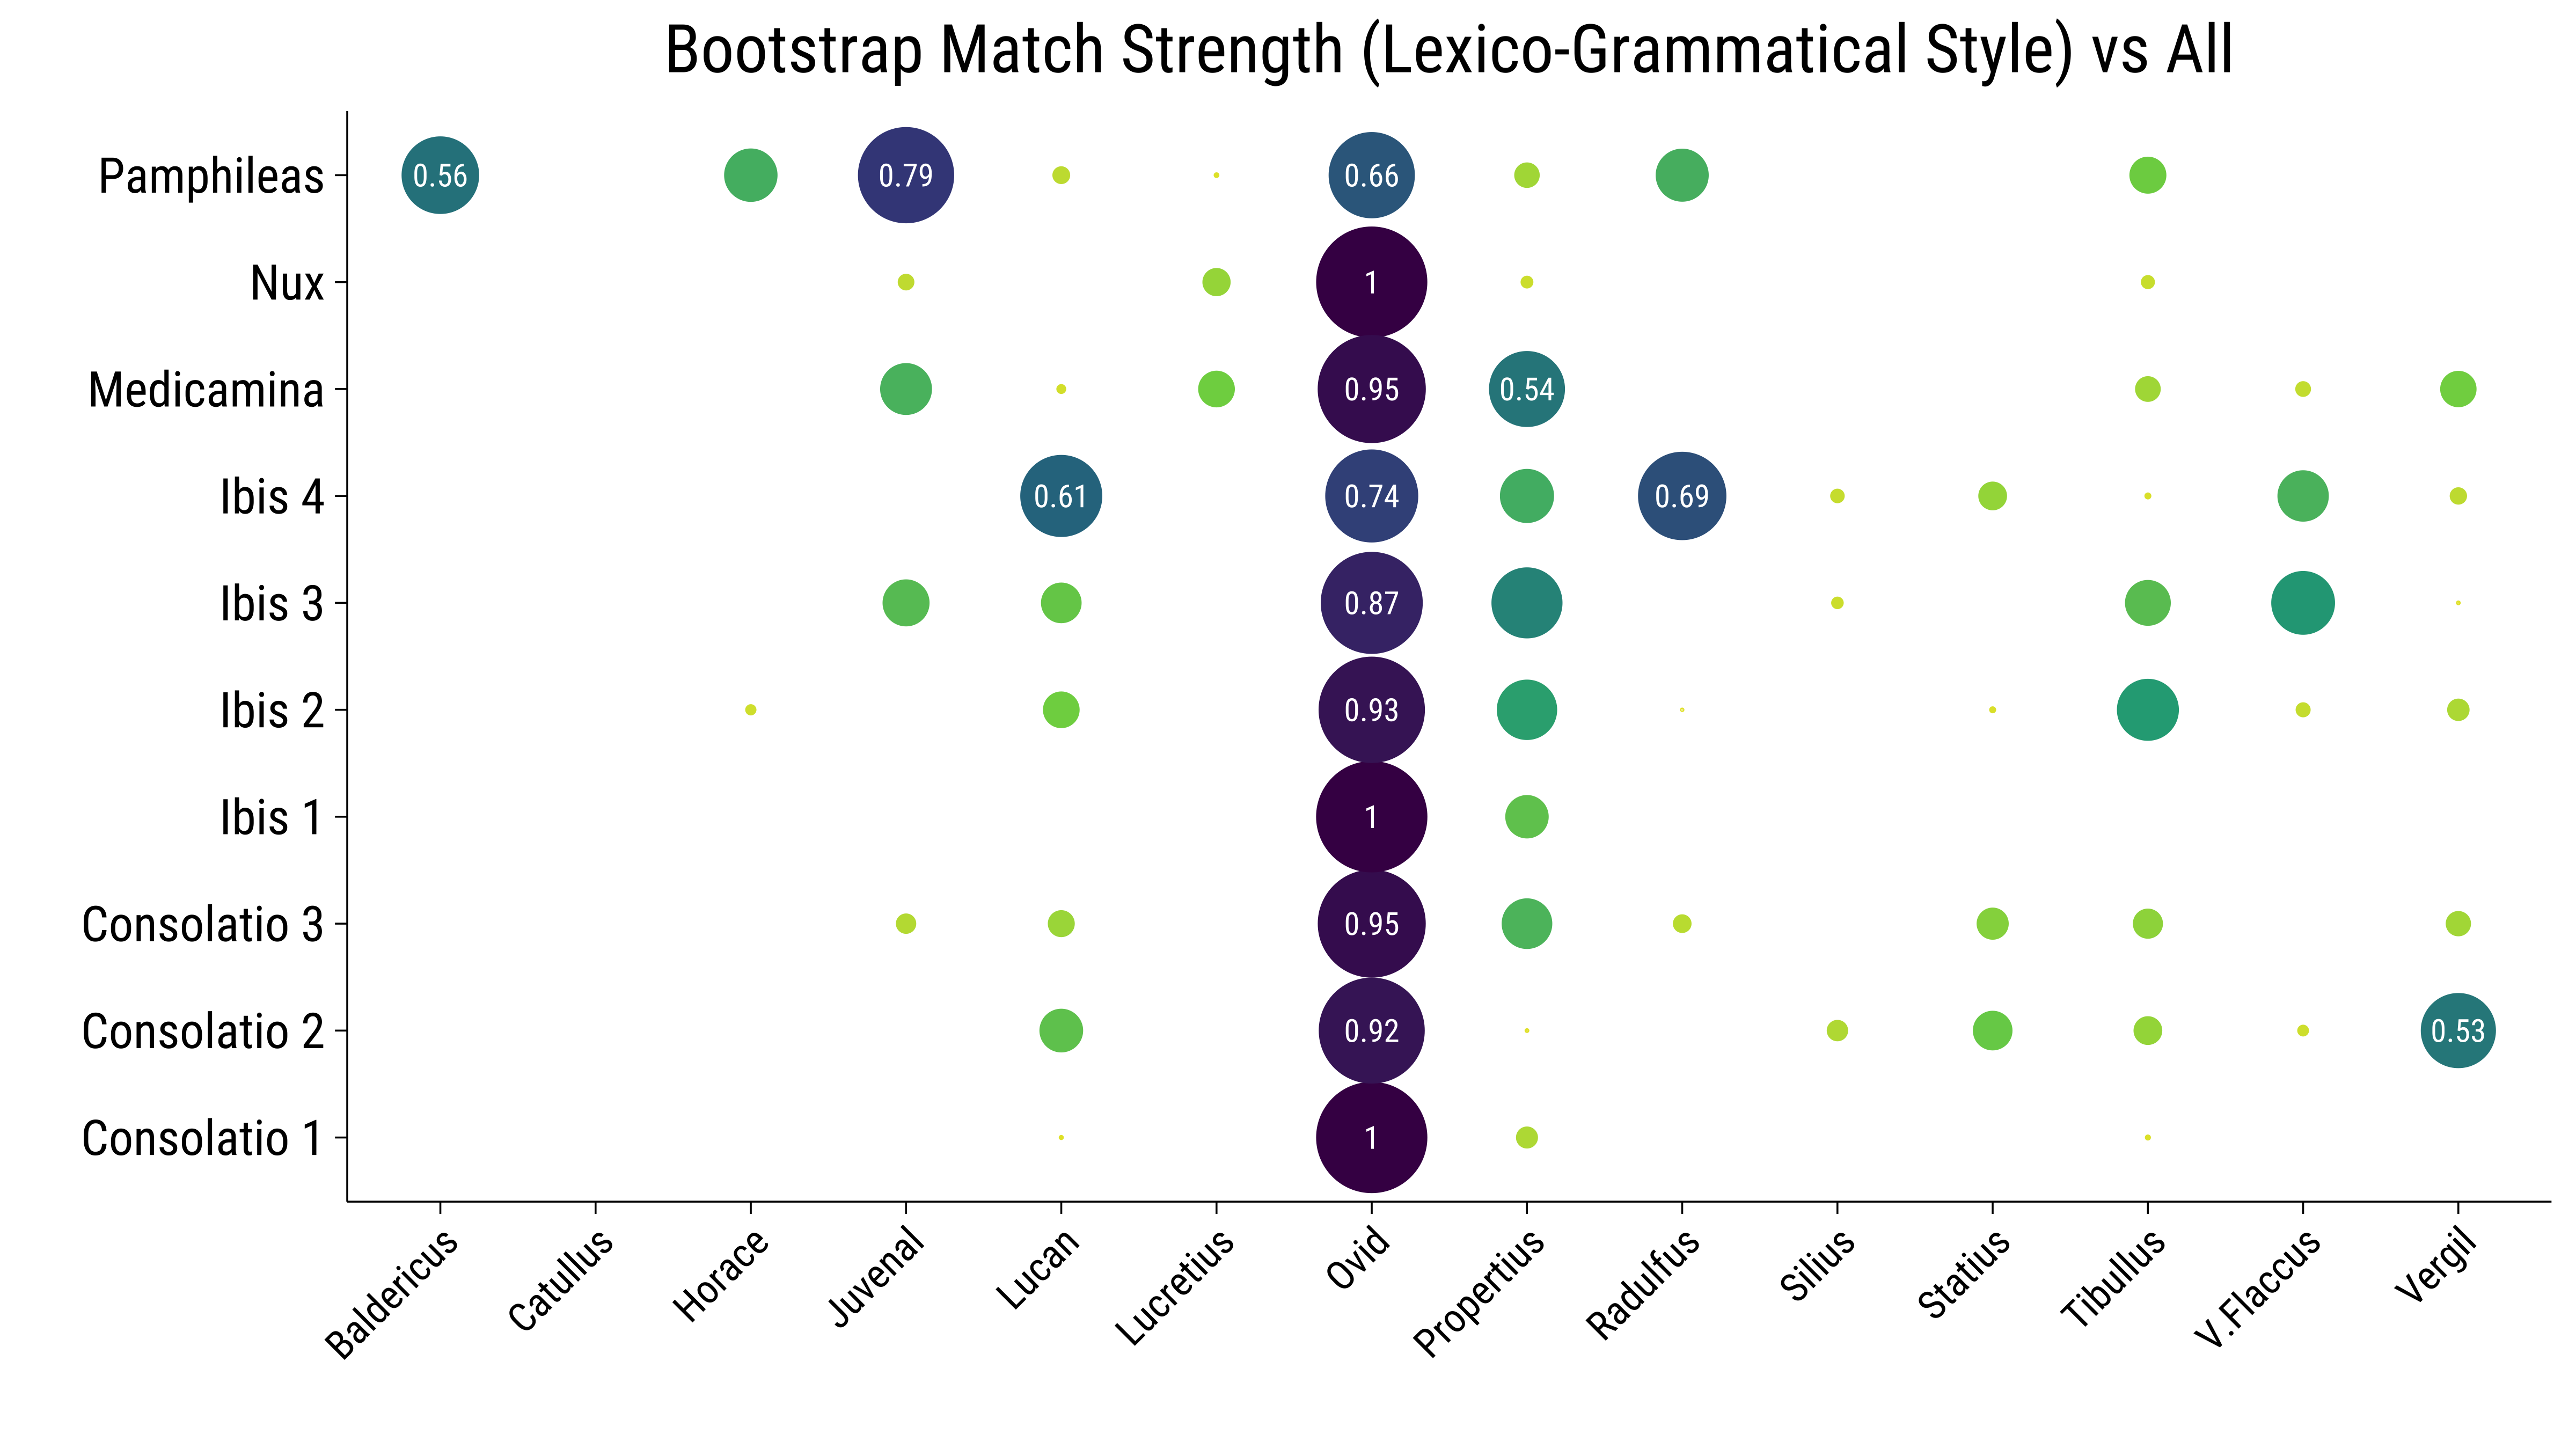

In [ ]:
%%R -i bubble -h 4.5 -w 8 -u in -r 600
library(ggridges)
library(paletteer)
library(ggplot2)
library(showtext)
library(dplyr)
font_add_google("Roboto Condensed", "fnt")
showtext_auto()

data <- bubble
bgcol <- 'white'
fgcol <- 'black'

hi <- data %>% filter(Match > 0.5)

p <- ggplot(data=data, aes(x=Author, y=Work)) +
geom_point(aes(size=Match,color=Match)) +
geom_text(data=hi, aes(label=round(Match,2)),family='fnt',size=2.5, color=bgcol)+

scale_size(range = c(-3, 11)) + 
scale_color_viridis_c(direction = -1) +
theme_bw() +
xlab("") +
ylab("") +
ggtitle("Bootstrap Match Strength (Lexico-Grammatical Style) vs All") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol,color=bgcol),
    plot.title = element_text(hjust = 0.5, size=15, family="fnt", color=fgcol),
    axis.line.x=element_line(linewidth=0.2,color=fgcol),
    axis.line.y=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.x=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.y=element_line(linewidth=0.2,color=fgcol),
    axis.text.x=element_text(size=9, family="fnt", color=fgcol, angle=45,hjust=1),
    axis.text.y=element_text(size=11, family="fnt", color=fgcol),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
)

# fn <- "../figures/bdi_ngram_bubble.pdf"
# ggsave(plot=p, fn, dpi=600, width=8, height=4.5, device=cairo_pdf)
p


In [256]:
# re-run the verification, to populate the _dist_arrays property

bdi_mm = BDIVerifier(
    metric="nini",
    nb_bootstrap_iter=1000,
    rnd_prop=0.35,
    random_state=np.random.default_rng(42),
)

bdi_mm.fit(scaled_X, labels)

bdi_mm.predict_proba(
    scaled_probs_X,
    [label_uniques.get_loc("Ovid")] * scaled_probs_X.shape[0],
    nb_imposters=50,
)

array([1.   , 0.982, 0.762, 1.   , 0.949, 0.978, 1.   , 0.96 , 0.918,
       0.843])

In [248]:
ovid_df = pd.DataFrame(dict(zip(problems.Poem, bdi_mm._dist_arrays)))
ovid_df

,Nux,Medicamina,Pamphileas,Consolatio 1,Consolatio 2,Consolatio 3,Ibis 1,Ibis 2,Ibis 3,Ibis 4
0,0.075400,0.045618,0.060577,0.107701,0.052992,0.033956,0.096985,0.060285,-0.000280,0.093208
1,0.038515,0.052826,0.046766,0.081874,0.027082,0.037320,0.119474,0.042625,0.074342,0.065283
2,0.118646,0.064086,-0.012763,0.096906,0.040541,0.050580,0.075895,0.106839,0.078200,-0.006303
3,0.060197,0.040133,0.022070,0.046615,0.014548,0.069509,0.080122,0.017295,0.003958,0.026623
4,0.054342,0.072759,0.024166,0.124152,0.041439,0.032326,0.120462,0.075003,0.056145,0.025013
...,...,...,...,...,...,...,...,...,...,...
995,0.106411,0.055428,0.025379,0.087258,0.045207,0.053152,0.113932,0.056449,0.071399,0.039107
996,0.074030,0.062863,0.025227,0.067071,0.035526,0.060418,0.094243,0.021886,0.031878,0.044121
997,0.071368,0.025928,0.047315,0.072626,-0.001859,0.029764,0.060666,0.053347,0.037699,0.072408
998,0.038820,0.019120,0.003648,0.106745,0.055094,0.028233,0.091455,0.055318,0.023421,0.096121


In [249]:
# for ggplot for this kind of plot it is easier to have 'long' tables, so we
# melt the dataframe so each observation for each text is a 'variable'. We add a
# column just so we can highlight the _Consolatio_ in a different colour.

ridge_df = pd.melt(ovid_df.T.reset_index(), id_vars="index")
ridge_df["highlight_color"] = "a"
ridge_df.loc[ridge_df["index"].str.startswith("Con"), "highlight_color"] = "b"
ridge_df.loc[ridge_df["index"].str.startswith("Pamp"), "highlight_color"] = "b"
ridge_df.loc[ridge_df["index"].str.startswith("Nux"), "highlight_color"] = "c"
ridge_df.head()

,index,variable,value,highlight_color
0,Nux,0,0.075400,c
1,Medicamina,0,0.045618,a
2,Pamphileas,0,0.060577,b
3,Consolatio 1,0,0.107701,b
4,Consolatio 2,0,0.052992,b


Picking joint bandwidth of 0.00562
Picking joint bandwidth of 0.00562


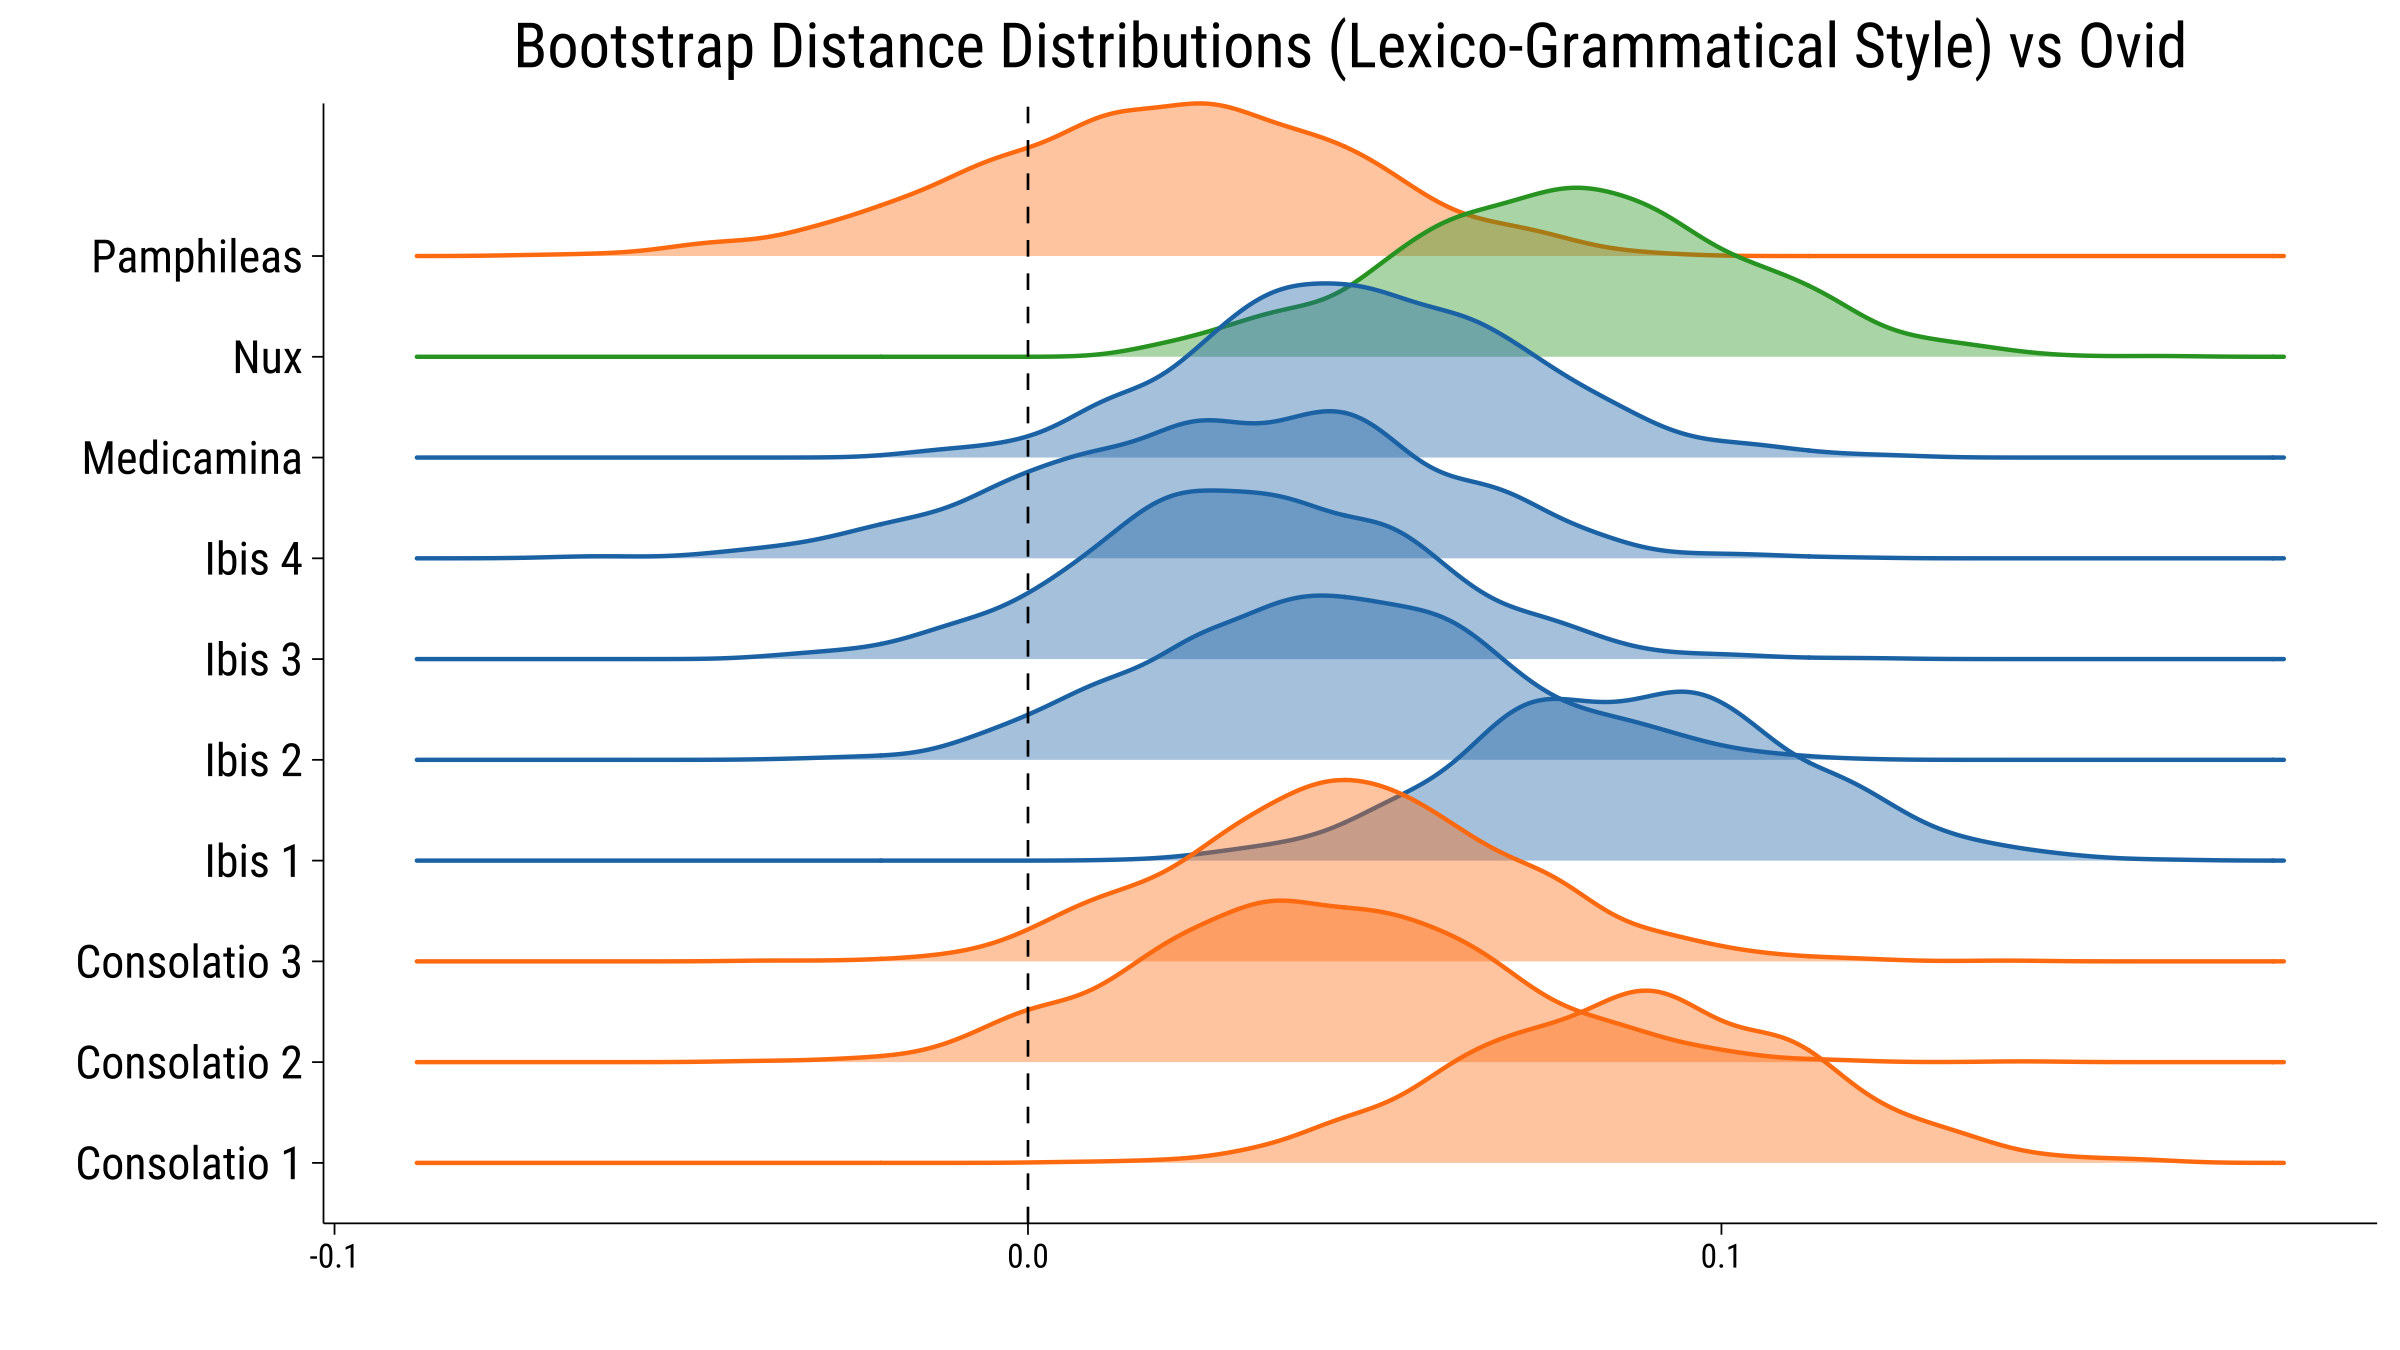

In [ ]:
%%R -i ridge_df -h 4.5 -w 8 -u in -r 300
library(ggridges)
library(paletteer)
library(ggplot2)
library(showtext)
font_add_google("Roboto Condensed", "fnt")
showtext_auto()

plt <- "ggsci::category10_d3"
bgcol <- 'white'
fgcol <- 'black'
data <- ridge_df

p <- ggplot(data=data,aes(value,y=index,fill=highlight_color,color=highlight_color)) +
coord_cartesian(clip = "off") +

ggridges::stat_density_ridges(
    quantile_lines = FALSE, quantiles = 2, 
    alpha = .4,
) +
geom_vline(xintercept=0, colour=fgcol, linetype='dashed', linewidth=0.3) +
scale_y_discrete() +
scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
theme_bw() +
xlab("") +
ylab("") +
ggtitle("Bootstrap Distance Distributions (Lexico-Grammatical Style) vs Ovid") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol,color=bgcol),
    plot.title = element_text(hjust = 0.5, size=15, family="fnt", color=fgcol),
    axis.line.x=element_line(linewidth=0.2,color=fgcol),
    axis.line.y=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.x=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.y=element_line(linewidth=0.2,color=fgcol),
    axis.text.x=element_text(size=8, family="fnt", color=fgcol),
    axis.text.y=element_text(size=11, family="fnt", color=fgcol),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
)


fn <- "../figures/bdi_ngram_med.pdf"
ggsave(plot=p, fn, dpi=600, width=8, height=4.5, device=cairo_pdf)
p